In [70]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import scipy.stats as stats

In [77]:
def num_of_molecules_per_mixture(dataset: Path, mixture_definitions: Path):
    dataset = pd.read_csv(dataset)
    dataset = dataset.loc[dataset["Dataset"] == "Snitz 1"]
    dataset["mixture_1_num_of_mol"] = ""
    dataset["mixture_2_num_of_mol"] = ""
    dataset["cumulative_num_of_mol"] = 0
    # pre-process, flip the similarity scores
    dataset["Experimental Values"] = 1 - dataset["Experimental Values"]
    mixture_definitions = pd.read_csv(mixture_definitions)
    for index, row in dataset.iterrows():
        dataset_id = row['Dataset']
        mixture_1_id = int(row['Mixture 1'])
        mixture_2_id = int(row['Mixture 2'])
        mixture_1_def = mixture_definitions.loc[(mixture_definitions['Dataset']==dataset_id) & (mixture_definitions["Mixture Label"] == mixture_1_id)]
        mixture_2_def = mixture_definitions.loc[(mixture_definitions['Dataset']==dataset_id) & (mixture_definitions["Mixture Label"] == mixture_2_id)]
        num_of_mol_mixture_1 = 43 - mixture_1_def.isna().sum(axis=1).values[0]
        num_of_mol_mixture_2 = 43 - mixture_2_def.isna().sum(axis=1).values[0]
        dataset.at[index, 'mixture_1_num_of_mol'] = num_of_mol_mixture_1
        dataset.at[index, 'mixture_2_num_of_mol'] = num_of_mol_mixture_2
        dataset.at[index, 'cumulative_num_of_mol'] = round(float(np.sqrt(int(num_of_mol_mixture_1)*int(num_of_mol_mixture_2))),5)
    
    return dataset

def k_molecules_split_plot(dataset: Path):
    dataset = pd.read_csv(dataset)
    mixture_1_max = dataset['mixture_1_num_of_mol'].max()
    mixture_2_max = dataset['mixture_2_num_of_mol'].max()
    k_molecules = {"k": [], "num_of_datapoints": []}
    for i in range(1, max(mixture_1_max, mixture_2_max)+1):
        num_of_datapoints = 0
        for index, row in dataset.iterrows():
            if (row['mixture_1_num_of_mol'] <= i) & (row['mixture_2_num_of_mol'] <= i): # if both mixtures have less than i molecules
                num_of_datapoints += 1
        k_molecules["k"].append(i)
        k_molecules["num_of_datapoints"].append(num_of_datapoints)
    print(k_molecules)
    plt.plot(k_molecules["k"], k_molecules["num_of_datapoints"])
    plt.xlabel("k")
    plt.ylabel("Number of datapoints")
    plt.title("Number of datapoints with less than k molecules in both mixtures for Snitz 1")
    plt.savefig("k_molecules_split_plot.png")
    plt.show()


def k_molecules_heatmap_between_mixtures(dataset: Path):
    dataset = pd.read_csv(dataset)
    mixture_1_max = dataset['mixture_1_num_of_mol'].max()
    mixture_2_max = dataset['mixture_2_num_of_mol'].max()
    heatmap_array = np.zeros((43, 43))
    for i in range(1, max(mixture_1_max, mixture_2_max)+1):
        for j in range(1, max(mixture_1_max, mixture_2_max)+1):
            num_of_datapoints = 0
            for index, row in dataset.iterrows():
                if (row['mixture_1_num_of_mol'] == j) & (row['mixture_2_num_of_mol'] == i) or (row['mixture_1_num_of_mol'] == i) & (row['mixture_2_num_of_mol'] == j): # if both mixtures have less than i molecules
                    num_of_datapoints += 1
            heatmap_array[i-1][j-1] = num_of_datapoints
    heatmap_array = np.flip(heatmap_array, axis=0)
    print(heatmap_array)
    m1 = range(1, max(mixture_1_max, mixture_2_max)+1)
    m2 = range(1, max(mixture_1_max, mixture_2_max)+1)
    fig, ax = plt.subplots(figsize=(30,30))
    im = ax.imshow(heatmap_array, vmin=0, vmax=10)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(m1)), labels=m1)
    ax.set_yticks(np.flip(np.arange(len(m2))), labels=m2)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(m1)):
        for j in range(len(m2)):
            text = ax.text(j, i, heatmap_array[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("Number of datapoints with exactly k molecules in both mixtures")
    plt.savefig("k_molecules_heatmap_plot.png")
    plt.show()

def less_than_k_molecules_heatmap_between_mixtures(dataset: Path):
    dataset = pd.read_csv(dataset)
    mixture_1_max = dataset['mixture_1_num_of_mol'].max()
    mixture_2_max = dataset['mixture_2_num_of_mol'].max()
    heatmap_array = np.zeros((43, 43))
    for i in range(1, max(mixture_1_max, mixture_2_max)+1):
        for j in range(1, max(mixture_1_max, mixture_2_max)+1):
            num_of_datapoints = 0
            for index, row in dataset.iterrows():
                if (row['mixture_1_num_of_mol'] <= j) & (row['mixture_2_num_of_mol'] <= i) or (row['mixture_1_num_of_mol'] <= i) & (row['mixture_2_num_of_mol'] <= j): # if both mixtures have less than i molecules
                    num_of_datapoints += 1
            heatmap_array[i-1][j-1] = num_of_datapoints
    heatmap_array = np.flip(heatmap_array, axis=0)
    print(heatmap_array)
    m1 = range(1, max(mixture_1_max, mixture_2_max)+1)
    m2 = range(1, max(mixture_1_max, mixture_2_max)+1)
    fig, ax = plt.subplots(figsize=(30,30))
    im = ax.imshow(heatmap_array, vmin=0, vmax=729)
    cbar = ax.figure.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(m1)), labels=m1)
    ax.set_yticks(np.flip(np.arange(len(m2))), labels=m2)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(m1)):
        for j in range(len(m2)):
            text = ax.text(j, i, heatmap_array[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("Number of datapoints with less than or equal to k molecules in both mixtures")
    plt.savefig("less_than_k_molecules_heatmap_plot.png")
    plt.show()

def distribution_greater_than_k_molecules(dataset: Path, k: int = 30):
    dataset = pd.read_csv(dataset)
    # find all datapoints with greater than k molecules in both mixtures
    filtered_dataset = dataset.loc[(dataset['mixture_1_num_of_mol'] >= k) & (dataset['mixture_2_num_of_mol'] >= k)]
    # compute mean and std of the similarity scores
    # plot histogram of the distribution of the number of datapoints per similarity score
    plt.hist(filtered_dataset['Experimental Values'], bins=20)
    plt.title(f"Distribution of similarity scores for datapoints with \n more than {k} molecules in both mixtures. \n n={len(filtered_dataset)} mean={filtered_dataset['Experimental Values'].mean()} std={filtered_dataset['Experimental Values'].std()}")
    plt.ylabel("Number of datapoints")
    plt.xlabel("Similarity Score")
    plt.savefig(f"distribution_greater_than_{k}_molecules_snitz1.png")

def distribution_less_than_k_molecules(dataset: Path, k: int = 10):
    dataset = pd.read_csv(dataset)
    # find all datapoints with greater than k molecules in both mixtures
    filtered_dataset = dataset.loc[(dataset['mixture_1_num_of_mol'] < k) & (dataset['mixture_2_num_of_mol'] < k)]
    # plot histogram of the distribution of the number of datapoints per similarity score
    plt.hist(filtered_dataset['Experimental Values'], bins=20)
    plt.title(f"Distribution of similarity scores for datapoints with \n less than {k} molecules in both mixtures. \n n={len(filtered_dataset)} mean={filtered_dataset['Experimental Values'].mean()} std={filtered_dataset['Experimental Values'].std()}")
    plt.ylabel("Number of datapoints")
    plt.xlabel("Similarity Score")
    plt.savefig(f"distribution_less_than_{k}_molecules_snitz1.png")


def distribution_of_avg_greater_than_k_molecules(dataset: Path):
    dataset = pd.read_csv(dataset)
    distribution: dict = {"k": [], "mean": [], "std": []}
    distribution_spread: dict = {"k": [], "similarity_score": []}
    for k in range(1, dataset["mixture_1_num_of_mol"].max()+1):
        filtered_dataset = dataset.loc[(dataset['mixture_1_num_of_mol'] >= k) & (dataset['mixture_2_num_of_mol'] >= k)]
        avg = filtered_dataset['Experimental Values'].mean()
        std = filtered_dataset['Experimental Values'].std()
        distribution["k"].append(k)
        distribution["mean"].append(avg)
        distribution["std"].append(std)
        distribution_spread["k"].extend([k]*len(filtered_dataset))
        distribution_spread["similarity_score"].extend(list(filtered_dataset['Experimental Values']))
    
    plt.title("Distribution of the average similarity score for \n datapoints with more than k molecules in both mixtures")
    plt.xlabel("k")
    plt.ylabel("Average similarity score")
    plt.ylim(0.3, 0.7)
    plt.scatter(distribution["k"], distribution["mean"])
    plt.savefig("distribution_of_avg_greater_than_k_molecules_snitz1.png")

    # sns.pointplot(distribution_spread, x="k", y='similarity_score', errorbar="sd")
    # plt.title("Distribution of the similarity score for \n datapoints with more than k molecules in both mixtures")
    # plt.xlabel("Number of molecules in mixture 1")
    # plt.ylabel("Similarity score")
    # plt.ylim(0.3, 0.7)
    # plt.savefig("distribution_of_avg_greater_than_k_molecules_snitz1_pointplot.png")

def distribution_of_cumulative_k_molecules(dataset: Path):
    dataset = pd.read_csv(dataset)
    dataset["cumulative_num_of_mol"] = dataset["cumulative_num_of_mol"].astype(float)
    distribution: dict = {"k": [], "mean": [], "std": []}
    for k in dataset["cumulative_num_of_mol"].unique():
        filtered_dataset = dataset.loc[dataset['cumulative_num_of_mol'] == k]
        avg = filtered_dataset['Experimental Values'].mean()
        std = filtered_dataset['Experimental Values'].std()
        distribution["k"].append(k)
        distribution["mean"].append(avg)
        distribution["std"].append(std)

    # pearson r correlation and p-value
    pers_r = stats.pearsonr(distribution["k"], distribution["mean"])
    print(pers_r.statistic, pers_r.pvalue)

    plt.scatter(distribution["k"], distribution["mean"])
    plt.errorbar(distribution["k"], distribution["mean"], yerr=distribution["std"], fmt='o')
    plt.plot(np.unique(distribution["k"]), np.poly1d(np.polyfit(distribution["k"], distribution["mean"], 1))(np.unique(distribution["k"])))
    # plot pearson r and p-value on top left of plot
    plt.text(0.2, 0.9, f"pearson r={round(pers_r.statistic, 2)} \n p-value={round(pers_r.pvalue, 10)}", ha='center', va='center', transform=plt.gca().transAxes)
    plt.xlabel(r"Number of components $\sqrt{n1*n2}$")
    plt.ylabel("Similarity score")
    plt.savefig("distribution_of_cumulative_k_molecules_snitz1.png")



In [33]:
dataset_path = Path("../datasets/k_molecules_split/mixtures_dataset.csv")
mixture_definitions_path = Path("../datasets/k_molecules_split/mixture_smi_definitions_clean.csv")

dataset = num_of_molecules_per_mixture(dataset_path, mixture_definitions_path)
dataset.to_csv("../datasets/k_molecules_split/mixtures_dataset_with_num_of_mol_snitz1.csv", index=False)

/var/folders/ff/8h_dksfn11xfp_fq0srryncc0000gn/T/ipykernel_82056/671950219.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.16228' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'cumulative_num_of_mol'] = round(float(np.sqrt(int(num_of_mol_mixture_1)*int(num_of_mol_mixture_2))),5)


{'k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], 'num_of_datapoints': [3, 3, 3, 14, 14, 14, 14, 14, 14, 30, 30, 33, 33, 33, 36, 36, 36, 36, 36, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 134, 134, 134, 147]}


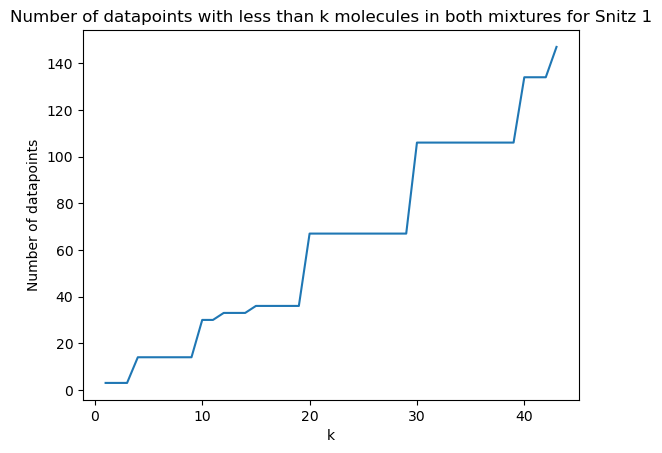

In [9]:
dataset_num_of_mol_path = Path("../datasets/k_molecules_split/mixtures_dataset_with_num_of_mol_snitz1.csv")
k_molecules_split_plot(dataset_num_of_mol_path)

0.6812370533520418 6.650198108524783e-06


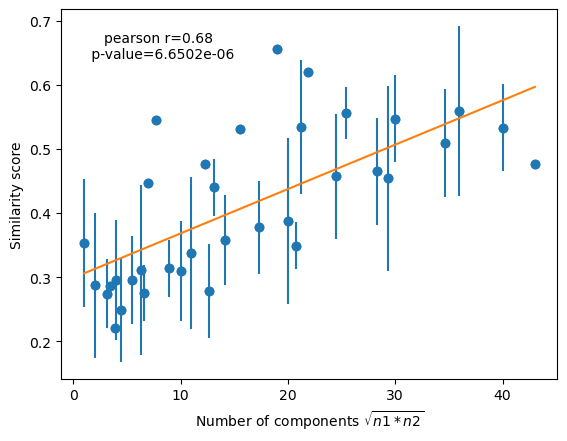

In [78]:
dataset_num_of_mol_path = Path("../datasets/k_molecules_split/mixtures_dataset_with_num_of_mol_snitz1.csv")
# distribution_greater_than_k_molecules(dataset_num_of_mol_path, 30)
# distribution_less_than_k_molecules(dataset_num_of_mol_path, 30)
# distribution_of_avg_greater_than_k_molecules(dataset_num_of_mol_path)
distribution_of_cumulative_k_molecules(dataset_num_of_mol_path)

In [16]:
dataset_num_of_mol_path = Path("../datasets/mixtures_dataset_with_num_of_mol.csv")
k_molecules_heatmap_between_mixtures(dataset_num_of_mol_path)
less_than_k_molecules_heatmap_between_mixtures(dataset_num_of_mol_path)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/mixtures_dataset_with_num_of_mol.csv'

In [ ]:
def k_molecules_split(k: int, dataset: Path, valid_percent: float = 0.1):
    dataset = pd.read_csv(dataset)
    dataset_train = dataset.loc[(dataset['mixture_1_num_of_mol'] <= k) & (dataset['mixture_2_num_of_mol'] <= k)]
    # get indices for training and validation
    train_set_indices, val_set_indices = train_test_split(dataset_train.index.to_numpy(), test_size=valid_percent)
    # get indices for testing
    dataset_test = dataset.loc[(dataset['mixture_1_num_of_mol'] > k) | (dataset['mixture_2_num_of_mol'] > k)]
    test_set_indices = dataset_test.index.to_numpy()
    indices: dict = {"train": train_set_indices, "val": val_set_indices, "test": test_set_indices}
    with open(f"../datasets/k_molecules_split_{k}.pkl", "wb") as f:
        pickle.dump(indices, f)

k_molecules_split(40, dataset_num_of_mol_path)

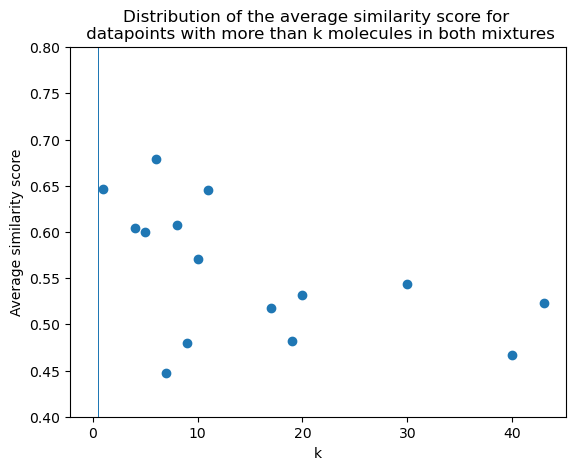

In [ ]:
dataset_num_of_mol_path = Path("../datasets/k_molecules_split/mixtures_dataset_with_num_of_mol_snitz1.csv")
distribution_greater_than_k_molecules(dataset_num_of_mol_path, 41)
# distribution_less_than_k_molecules(dataset_num_of_mol_path, 30)
distribution_of_avg_greater_than_k_molecules(dataset_num_of_mol_path)